# ENTRENAMIENTO DE MODELOS: Random Forest + LSTM

## Objetivo
Entrenar dos modelos predictivos para forecasting de precios Solana:
1. **Random Forest** - Modelo no-lineal de referencia
2. **LSTM** - Red neuronal para capturar dependencias temporales

### Salida:
- Modelos guardados (.pkl, .h5)
- Métricas de evaluación
- Análisis de errores


In [1]:
# activar entorno virtual
! .\venv\Scripts\Activate.ps1
# ! pip install scikit-learn
# pip install jupyter
# pip install ipykernel
# ! pip install tensorflow

El sistema no puede encontrar la ruta especificada.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Utilidades
import pickle
import json

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow/Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Configurar matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("Librerías importadas correctamente")



Librerías importadas correctamente


## 2. Cargar Features Preparados


In [3]:
df = pd.read_csv('../data/features_prepared.csv')

print(f"Features cargados: {df.shape}")
print("\nColumnas:")
print(df.columns.tolist())
print("\nPrimeras filas:")
df.head()


Features cargados: (1856, 12)

Columnas:
['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of trades', 'Returns', 'SMA20', 'Volatility_20', 'Target_Price', 'Target_Direction']

Primeras filas:


,Open time,Open,High,Low,Close,Volume,Number of trades,Returns,SMA20,Volatility_20,Target_Price,Target_Direction
0,2020-08-31,4.4127,4.8865,4.1000,4.7435,1497129.12,23396,0.070550,3.496800,0.086276,4.3397,0
1,2020-09-01,4.7432,4.9475,4.3000,4.3397,1267574.76,20174,-0.085127,3.525995,0.084828,4.1700,0
2,2020-09-02,4.3213,4.3506,3.6600,4.1700,2002058.36,25545,-0.039104,3.547995,0.085482,3.5051,0
3,2020-09-03,4.1700,4.4590,3.4772,3.5051,3275612.26,37166,-0.159448,3.552755,0.091178,3.5301,1
4,2020-09-04,3.5062,3.8346,3.1739,3.5301,2052197.24,23918,0.007132,3.570610,0.089462,2.6052,0


## 3. Preparación de Datos


In [4]:
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA20','Volatility_20','Number of trades'
]

X = df[feature_cols].copy()
y = df['Target_Price'].copy()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

print("\nFeature names:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")


Features (X): (1856, 8)
Target (y): (1856,)

Feature names:
  1. Open
  2. High
  3. Low
  4. Close
  5. Volume
  6. SMA20
  7. Volatility_20
  8. Number of trades


## 4. Escalado de Datos

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos escalados")
print(f"   Media (primeras 3): {X_scaled.mean(axis=0)[:3]}")
print(f"   Std (primeras 3): {X_scaled.std(axis=0)[:3]}")

with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler guardado: models/scaler.pkl")


Datos escalados
   Media (primeras 3): [1.83761052e-16 6.12536841e-17 3.06268421e-17]
   Std (primeras 3): [1. 1. 1.]
Scaler guardado: models/scaler.pkl


## 5. Train/Test Split


In [6]:
test_size = 0.2
split_idx = int(len(X_scaled) * (1 - test_size))

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.values[:split_idx], y.values[split_idx:]

print("Train/Test split (80/20)")
print(f"   Train: {X_train.shape[0]}")
print(f"   Test: {X_test.shape[0]}")


Train/Test split (80/20)
   Train: 1484
   Test: 372


## 6. MODELO 1: Random Forest Regressor


In [7]:
# ========== RANDOM FOREST COMPLETO ==========
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

rf_params = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1
}

print("Entrenando Random Forest...")
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# CALCULAR TODAS LAS MÉTRICAS
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred) 
rf_test_r2 = r2_score(y_test, rf_test_pred)

print("RANDOM FOREST RESULTS")
print(f"Train RMSE: ${rf_train_rmse:.2f}")
print(f"Test RMSE:  ${rf_test_rmse:.2f}")
print(f"Train MAE:  ${rf_train_mae:.2f}")
print(f"Test MAE:   ${rf_test_mae:.2f}")
print(f"Train R²:   {rf_train_r2:.4f}")
print(f"Test R²:    {rf_test_r2:.4f}")

with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Random Forest guardado")

Entrenando Random Forest...
RANDOM FOREST RESULTS
Train RMSE: $2.49
Test RMSE:  $9.24
Train MAE:  $1.39
Test MAE:   $6.85
Train R²:   0.9984
Test R²:    0.9340
Random Forest guardado


## 7. MODELO 2: LSTM Neural Network


In [8]:
lookback = 20

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, lookback)

lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True,
         input_shape=(lookback, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

lstm_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Entrenar LSTM


In [9]:
# ========== LSTM COMPLETO ==========
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Entrenando LSTM...")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# PREDICCIONES COMPLETAS
lstm_train_pred = lstm_model.predict(X_train_seq, verbose=0).flatten()
lstm_test_pred = lstm_model.predict(X_test_seq, verbose=0).flatten()

# CALCULAR TODAS LAS MÉTRICAS
lstm_train_rmse = np.sqrt(mean_squared_error(y_train_seq, lstm_train_pred))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_test_pred))
lstm_train_mae = mean_absolute_error(y_train_seq, lstm_train_pred)
lstm_test_mae = mean_absolute_error(y_test_seq, lstm_test_pred)
lstm_train_r2 = r2_score(y_train_seq, lstm_train_pred)
lstm_test_r2 = r2_score(y_test_seq, lstm_test_pred)

print("LSTM RESULTS")
print(f"Train RMSE: ${lstm_train_rmse:.2f}")
print(f"Test RMSE:  ${lstm_test_rmse:.2f}")
print(f"Train MAE:  ${lstm_train_mae:.2f}")
print(f"Test MAE:   ${lstm_test_mae:.2f}")
print(f"Train R²:   {lstm_train_r2:.4f}")
print(f"Test R²:    {lstm_test_r2:.4f}")

lstm_model.save('../models/lstm_model.h5')
print("LSTM guardado")


Entrenando LSTM...


LSTM RESULTS
Train RMSE: $17.67
Test RMSE:  $59.33
Train MAE:  $10.80
Test MAE:   $39.36
Train R²:   0.9184
Test R²:    -1.6926
LSTM guardado


## 9. Visualizar Training History

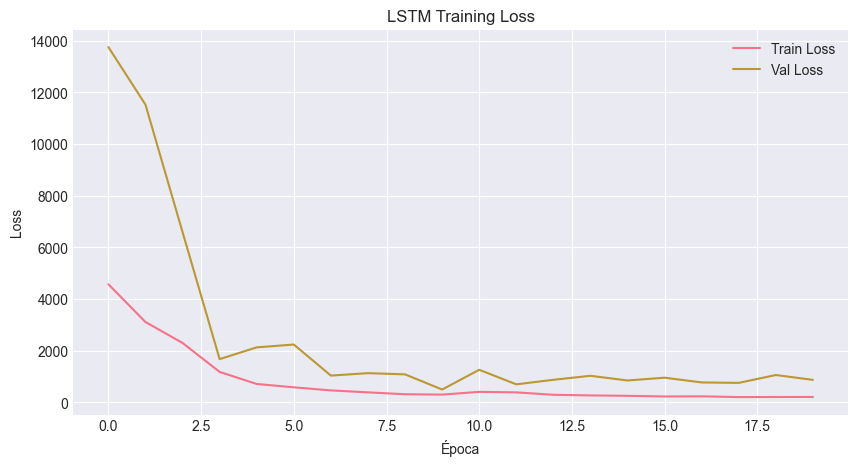

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.savefig('../output/LSTM_Training_Loss.png', dpi=300, bbox_inches='tight')


## 10. Comparación de Modelos


In [11]:
# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Métrica': ['RMSE Train', 'RMSE Test', 'MAE Train', 'MAE Test', 'R² Train', 'R² Test'],
    'Random Forest': [
        f"${rf_train_rmse:.2f}",
        f"${rf_test_rmse:.2f}",
        f"${rf_train_mae:.2f}",
        f"${rf_test_mae:.2f}",
        f"{rf_train_r2:.4f}",
        f"{rf_test_r2:.4f}"
    ],
    'LSTM': [
        f"${lstm_train_rmse:.2f}",
        f"${lstm_test_rmse:.2f}",
        f"${lstm_train_mae:.2f}",
        f"${lstm_test_mae:.2f}",
        f"{lstm_train_r2:.4f}",
        f"{lstm_test_r2:.4f}"
    ]
})

print("\n" + "="*40)
print("        COMPARACIÓN DE MODELOS")
print("="*40)
print(comparison_df.to_string(index=False))

# Determinar mejor modelo
if rf_test_rmse < lstm_test_rmse:
    best_model = "Random Forest"
    print(f"\n🏆 Mejor modelo en TEST: {best_model}")
else:
    best_model = "LSTM"
    print(f"\n🏆 Mejor modelo en TEST: {best_model}")

print(f"   Diferencia RMSE: ${abs(rf_test_rmse - lstm_test_rmse):.2f}")



        COMPARACIÓN DE MODELOS
   Métrica Random Forest    LSTM
RMSE Train         $2.49  $17.67
 RMSE Test         $9.24  $59.33
 MAE Train         $1.39  $10.80
  MAE Test         $6.85  $39.36
  R² Train        0.9984  0.9184
   R² Test        0.9340 -1.6926

🏆 Mejor modelo en TEST: Random Forest
   Diferencia RMSE: $50.09


## 11. Análisis de Errores - ¿CUÁNDO FALLA EL MODELO?


In [12]:
# Calcular residuos
rf_residuals = y_test - rf_test_pred
lstm_residuals = y_test_seq - lstm_test_pred

print("\n" + "="*40)
print("               ANÁLISIS DETALLADO DE ERRORES")
print("="*40)

print(f"\nRANDOM FOREST:")
print(f"   Error máximo: ${np.max(np.abs(rf_residuals)):.2f}")
print(f"   Error mínimo: ${np.min(np.abs(rf_residuals)):.2f}")
print(f"   Error promedio: ${np.mean(np.abs(rf_residuals)):.2f}")
print(f"   Percentil 95: ${np.percentile(np.abs(rf_residuals), 95):.2f}")
print(f"   % predicciones con error < $10: {(np.abs(rf_residuals) < 10).sum() / len(rf_residuals) * 100:.1f}%")

print(f"\nLSTM:")
print(f"   Error máximo: ${np.max(np.abs(lstm_residuals)):.2f}")
print(f"   Error mínimo: ${np.min(np.abs(lstm_residuals)):.2f}")
print(f"   Error promedio: ${np.mean(np.abs(lstm_residuals)):.2f}")
print(f"   Percentil 95: ${np.percentile(np.abs(lstm_residuals), 95):.2f}")
print(f"   % predicciones con error < $10: {(np.abs(lstm_residuals) < 10).sum() / len(lstm_residuals) * 100:.1f}%")



               ANÁLISIS DETALLADO DE ERRORES

RANDOM FOREST:
   Error máximo: $41.84
   Error mínimo: $0.00
   Error promedio: $6.85
   Percentil 95: $18.28
   % predicciones con error < $10: 74.2%

LSTM:
   Error máximo: $395.87
   Error mínimo: $0.95
   Error promedio: $39.36
   Percentil 95: $98.24
   % predicciones con error < $10: 20.2%


## 12. Visualizar Residuos


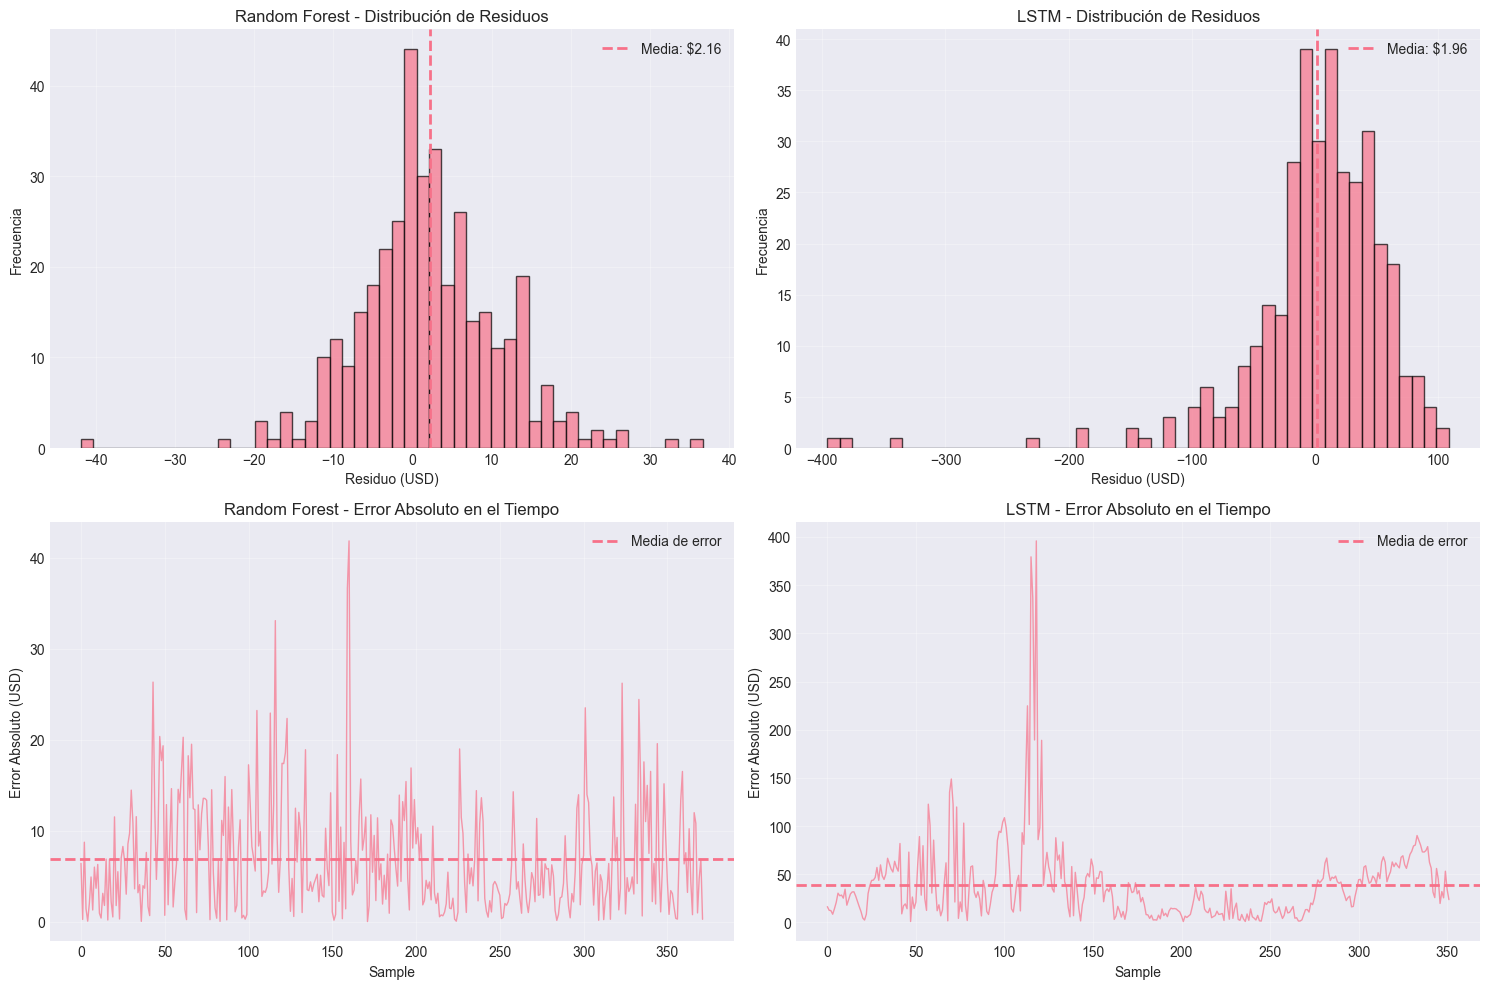

Gráficas de errores guardadas


In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# RF Residuals
ax1.hist(rf_residuals, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(rf_residuals.mean(), linestyle='--', linewidth=2, label=f'Media: ${rf_residuals.mean():.2f}')
ax1.set_title('Random Forest - Distribución de Residuos')
ax1.set_xlabel('Residuo (USD)')
ax1.set_ylabel('Frecuencia')
ax1.legend()
ax1.grid(True, alpha=0.3)

# LSTM Residuals
ax2.hist(lstm_residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(lstm_residuals.mean(), linestyle='--', linewidth=2, label=f'Media: ${lstm_residuals.mean():.2f}')
ax2.set_title('LSTM - Distribución de Residuos')
ax2.set_xlabel('Residuo (USD)')
ax2.set_ylabel('Frecuencia')
ax2.legend()
ax2.grid(True, alpha=0.3)

# RF Error over time
ax3.plot(np.abs(rf_residuals), linewidth=1, alpha=0.7)
ax3.axhline(np.mean(np.abs(rf_residuals)), linestyle='--', linewidth=2, label='Media de error')
ax3.set_title('Random Forest - Error Absoluto en el Tiempo')
ax3.set_xlabel('Sample')
ax3.set_ylabel('Error Absoluto (USD)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# LSTM Error over time
ax4.plot(np.abs(lstm_residuals), linewidth=1, alpha=0.7)
ax4.axhline(np.mean(np.abs(lstm_residuals)), linestyle='--', linewidth=2, label='Media de error')
ax4.set_title('LSTM - Error Absoluto en el Tiempo')
ax4.set_xlabel('Sample')
ax4.set_ylabel('Error Absoluto (USD)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráficas de errores guardadas")


## 13. Predicciones vs Actuals


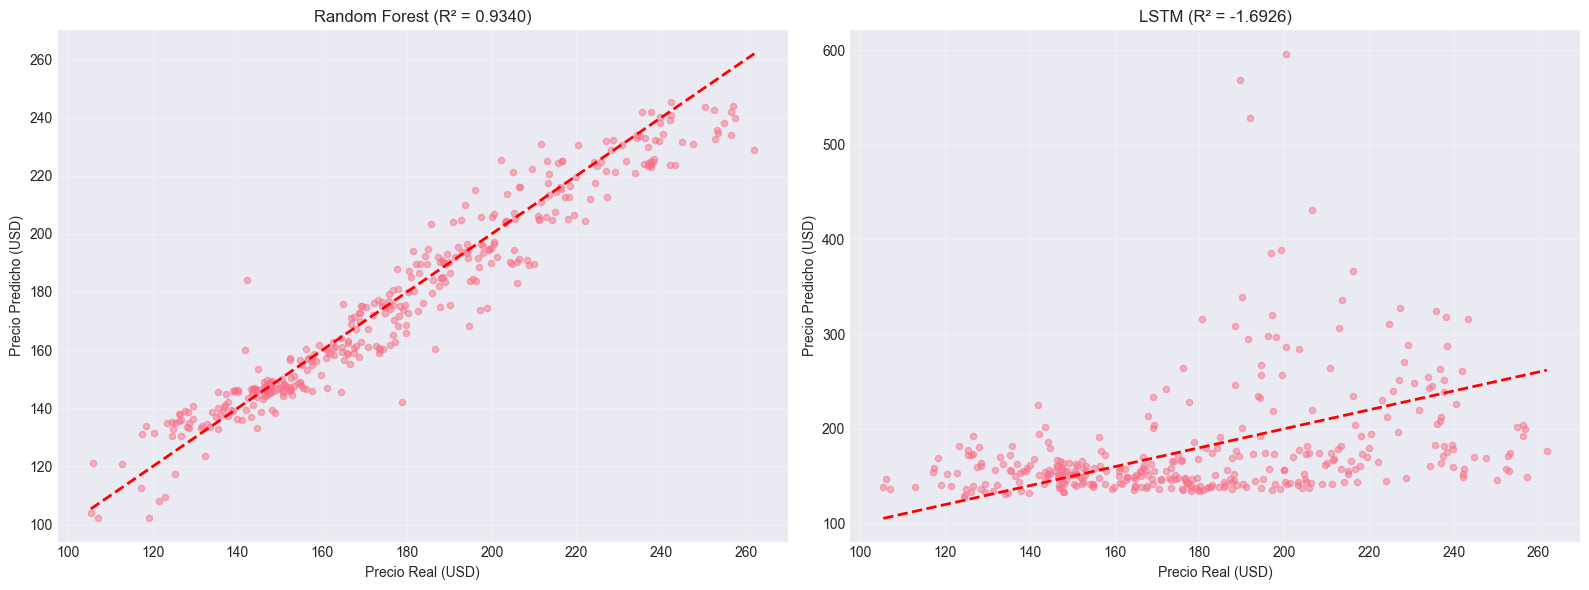

Gráficas de predicciones guardadas


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
ax1.scatter(y_test, rf_test_pred, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Precio Real (USD)')
ax1.set_ylabel('Precio Predicho (USD)')
ax1.set_title(f'Random Forest (R² = {rf_test_r2:.4f})')
ax1.grid(True, alpha=0.3)

# LSTM
ax2.scatter(y_test_seq, lstm_test_pred, alpha=0.5, s=20)
ax2.plot([y_test_seq.min(), y_test_seq.max()], [y_test_seq.min(), y_test_seq.max()], 'r--', lw=2)
ax2.set_xlabel('Precio Real (USD)')
ax2.set_ylabel('Precio Predicho (USD)')
ax2.set_title(f'LSTM (R² = {lstm_test_r2:.4f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráficas de predicciones guardadas")


In [15]:
# ======================
# EXPORTAR MEJOR MODELO PARA VERCEL
# ======================

import joblib
import json
from datetime import datetime

print("Exportando MEJOR modelo (Random Forest)...")

# 1. Guardar el Random Forest (tu mejor modelo)
joblib.dump(rf_model, '../models/rf_model_best.pkl')
print("Random Forest guardado como 'rf_model_best.pkl'")

# 2. También guardar como 'model.pkl' para que Vercel lo encuentre fácil
joblib.dump(rf_model, '../models/model.pkl')
print("También guardado como 'model.pkl' (para compatibilidad)")

# 3. Guardar información del modelo
model_info = {
    'model_name': 'Random_Forest_Solana_Predictor',
    'model_type': 'RandomForestRegressor',
    'version': '1.0',
    'performance': {
        'test_rmse': float(rf_test_rmse),
        'test_mae': float(rf_test_mae),
        'test_r2': float(rf_test_r2),
        'avg_error': float(np.mean(np.abs(rf_residuals))),
        'pct_error_under_10': float((np.abs(rf_residuals) < 10).sum() / len(rf_residuals) * 100)
    },
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'features': list(X_train.columns) if hasattr(X_train, 'columns') else f"{X_train.shape[1]} features",
    'hyperparameters': rf_params,
    'note': 'MEJOR MODELO - Supera al LSTM en todas las metricas'
}

with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("Información del modelo guardada en 'model_info.json'")
print("\n" + "="*50)
print("RESUMEN DEL MEJOR MODELO:")
print(f"   • RMSE Test: ${rf_test_rmse:.2f}")
print(f"   • MAE Test: ${rf_test_mae:.2f}")
print(f"   • R² Test: {rf_test_r2:.4f}")
print(f"   • Error promedio: ${np.mean(np.abs(rf_residuals)):.2f}")
print(f"   • Predicciones con error < $10: {(np.abs(rf_residuals) < 10).sum() / len(rf_residuals) * 100:.1f}%")
print("="*50)

Exportando MEJOR modelo (Random Forest)...
Random Forest guardado como 'rf_model_best.pkl'
También guardado como 'model.pkl' (para compatibilidad)
Información del modelo guardada en 'model_info.json'

RESUMEN DEL MEJOR MODELO:
   • RMSE Test: $9.24
   • MAE Test: $6.85
   • R² Test: 0.9340
   • Error promedio: $6.85
   • Predicciones con error < $10: 74.2%
